### Pemeriksaan Environment

### Periksa Penggunaan GPU oleh Tensorflow

In [81]:
# import tensorflow as tf

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# if tf.config.list_physical_devices('GPU'):
#     print("TensorFlow is using GPU.")
# else:
#     print("TensorFlow is not using GPU.")

### Install Dependency jika belum diinstal pada environment

In [82]:
# %pip install tensorflow
# %pip install keras_tuner
# %pip install streamlit
# %pip install matplotlib

### Periksa Dataset

Periksa gambar yang mungkin menyebabkan error pada image_dateset_from_directory.

In [83]:
import os
import tensorflow as tf

DATA_DIR = '/mnt/g/My Drive/college/Smt4/PCP/DatasetTekstur'
print("Mencari file penyebab error menggunakan TensorFlow...")

problematic_file = None

for class_folder in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_folder)
    if not os.path.isdir(class_path):
        continue
        
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        try:
            # Coba baca dan decode gambar menggunakan TensorFlow
            img_bytes = tf.io.read_file(file_path)
            decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
            # Jika error ini muncul, kita menemukan pelakunya!
            problematic_file = file_path
            print(f"\n---> DITEMUKAN! File penyebab masalah adalah: {problematic_file}")
            print(f"Error: {e}")
            break # Hentikan pencarian
    if problematic_file:
        break

if not problematic_file:
    print("\nTidak ditemukan file spesifik yang menyebabkan error InvalidArgument.")

Mencari file penyebab error menggunakan TensorFlow...

Tidak ditemukan file spesifik yang menyebabkan error InvalidArgument.


### Import Semua Package

In [84]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


### Konfigurasi Parameter Utama

Mendefinisikan semua parameter penting di satu tempat agar mudah diubah.

In [85]:
# Ganti dengan path ke direktori dataset Anda
from pathlib import Path
DATA_DIR = Path("/mnt/g/My Drive/college/Smt4/PCP/DatasetTekstur")

# Parameter untuk pemrosesan gambar dan pelatihan
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
CLASSES = ['batu', 'kain', 'kayu']

### Memuat Dataset dan Membagi Dataset Training dan Validation

In [86]:
# Muat dataset dari direktori, langsung bagi menjadi train dan validation
# 80% data untuk training, 20% untuk validasi sementara
initial_train_ds, initial_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASSES,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="both",
    seed=1337,
    batch_size=BATCH_SIZE,
)

# Ambil 50% dari set validasi sementara untuk dijadikan set test final
# Sisanya (50%) akan menjadi set validasi yang sebenarnya
val_batches = tf.data.experimental.cardinality(initial_val_ds)
test_ds = initial_val_ds.take(val_batches // 2)
val_ds = initial_val_ds.skip(val_batches // 2)

print(f"Jumlah batch di set Pelatihan: {tf.data.experimental.cardinality(initial_train_ds)}")
print(f"Jumlah batch di set Validasi: {tf.data.experimental.cardinality(val_ds)}")
print(f"Jumlah batch di set Pengujian: {tf.data.experimental.cardinality(test_ds)}")

# Optimalkan performa dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = initial_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 300 files belonging to 3 classes.
Using 240 files for training.
Using 60 files for validation.
Jumlah batch di set Pelatihan: 8
Jumlah batch di set Validasi: 1
Jumlah batch di set Pengujian: 1


### Membuat layer augmentasi data

Lapisan ini akan diterapkan pada gambar selama pelatihan untuk menciptakan variasi dan mencegah model menghafal.

In [87]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
], name="data_augmentation")

### Membangun model baru dengan transfer learning bersama model EfficientNetB0

In [88]:
# Pra-pemrosesan khusus untuk EfficientNet
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Muat model dasar (base model) tanpa lapisan klasifikasi di atasnya
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,  # Jangan sertakan lapisan Dense terakhir
    weights='imagenet'
)

# Bekukan (freeze) lapisan-lapisan di base model agar tidak ikut terlatih di awal
base_model.trainable = False

# Buat arsitektur model lengkap
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Mode inference untuk base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Tampilkan arsitektur model
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Pelatihan Tahap 1 - Feature Extraction

In [89]:
initial_epochs = 20

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Memulai Pelatihan Tahap 1 (Feature Extraction)...")
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds
)

Memulai Pelatihan Tahap 1 (Feature Extraction)...
Epoch 1/20


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 594ms/step - accuracy: 0.5247 - loss: 0.9687 - val_accuracy: 0.8929 - val_loss: 0.6653
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.8491 - loss: 0.6104 - val_accuracy: 0.8571 - val_loss: 0.4830
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9271 - loss: 0.4196 - val_accuracy: 0.9286 - val_loss: 0.3681
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.9558 - loss: 0.3075 - val_accuracy: 0.9286 - val_loss: 0.3015
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.9788 - loss: 0.2311 - val_accuracy: 0.9286 - val_loss: 0.2671
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.9650 - loss: 0.1961 - val_accuracy: 0.9286 - val_loss: 0.2408
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9662 - loss: 0.1782 - val_accuracy: 0.9643 - val_loss: 0.2221
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.9658 - loss: 0.1577 - val_accuracy: 0.9643 - val_loss: 0.2158
Ep

### Pelatihan Tahap 2 - Melakukan Fine-tuning pada Model

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

# Cairkan base model
base_model.trainable = True

# Biarkan lapisan bawah tetap beku, hanya latih lapisan atas
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Gunakan Learning Rate Scheduler untuk penyesuaian yang lebih halus
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-6,  # Learning rate
    decay_steps=1000
)

# Tambahkan earlystopping untuk mencegah overfitting agresif
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Tingkatkan kesabaran agar tidak berhenti terlalu cepat
    verbose=1,
    restore_best_weights=True
)

# Kompilasi ulang model dengan learning rate yang sangat rendah
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary() # Lihat berapa banyak lapisan yang sekarang bisa dilatih

fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

print("\nMemulai Pelatihan Tahap 2 (Fine-Tuning)...")
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,291,547 (12.56 MB)

 Non-trainable params: 761,867 (2.91 MB)


Memulai Pelatihan Tahap 2 (Fine-Tuning)...
Epoch 20/40


E0000 00:00:1750587426.927124   17078 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_15_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 515ms/step - accuracy: 0.8516 - loss: 0.4927 - val_accuracy: 0.9643 - val_loss: 0.1515
Epoch 21/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.8272 - loss: 0.4995 - val_accuracy: 0.9643 - val_loss: 0.1467
Epoch 22/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.8055 - loss: 0.4690 - val_accuracy: 0.9643 - val_loss: 0.1436
Epoch 23/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.8800 - loss: 0.4011 - val_accuracy: 0.9643 - val_loss: 0.1415
Epoch 24/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8143 - loss: 0.4628 - val_accuracy: 0.9643 - val_loss: 0.1407
Epoch 25/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.8362 - loss: 0.4362 - val_accuracy: 0.9643 - val_loss: 0.1409
Epoch 26/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.9017 - loss: 0.3909 - val_accuracy: 0.9643 - val_loss: 0.1413
Epoch 27/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9084 - loss: 0.3538 - val_accuracy: 0.9643 - val_loss: 0.

### Visualisasi hasil pelatihan

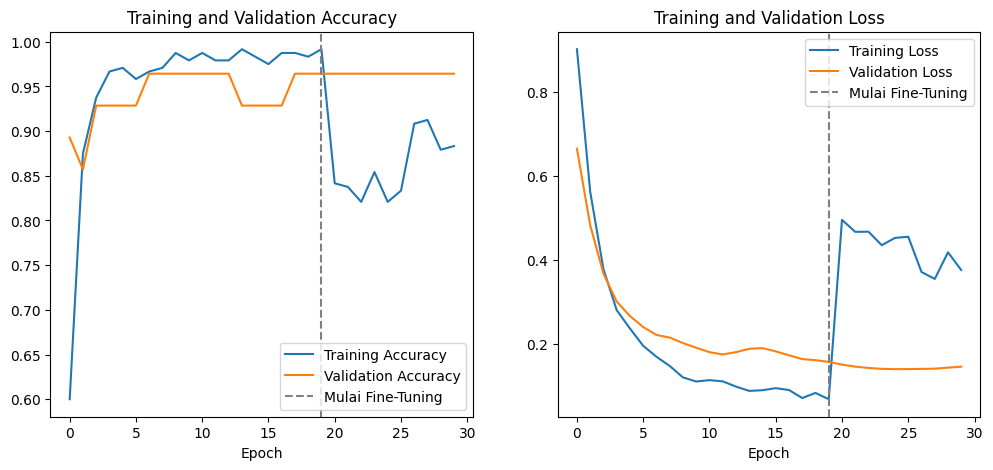

In [91]:
# Gabungkan history dari kedua tahap pelatihan
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Mulai Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Mulai Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

### Evaluasi Final

In [92]:
print("Mengevaluasi model pada set data pengujian...")
loss, accuracy = model.evaluate(test_ds)
print(f"Akurasi pada data test: {accuracy:.2%}")

Mengevaluasi model pada set data pengujian...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 1.0000 - loss: 0.1029
Akurasi pada data test: 100.00%


### Menganalisis kesalahan dengan Confusion Matrix

Classification Report:

              precision    recall  f1-score   support

        batu       1.00      1.00      1.00         8
        kain       1.00      1.00      1.00        10
        kayu       1.00      1.00      1.00        14

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



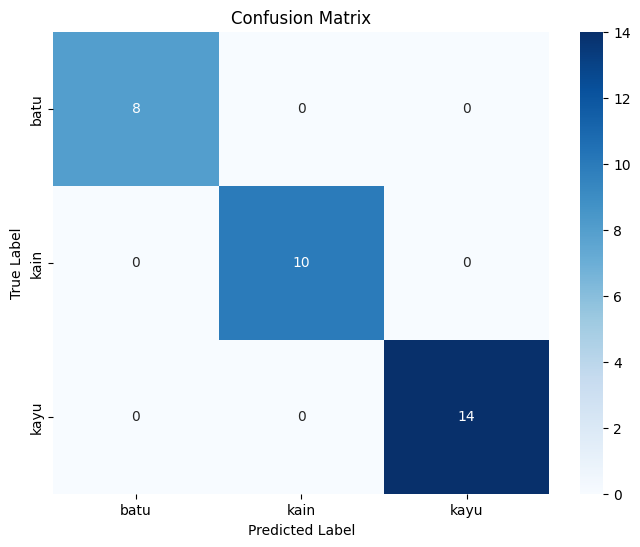

In [93]:
# Dapatkan prediksi dan label asli dari set test
y_pred = []
y_true = []
for image_batch, label_batch in test_ds:
   y_true.extend(label_batch.numpy())
   preds = model.predict(image_batch, verbose=0)
   y_pred.extend(np.argmax(preds, axis=-1))

# Tampilkan Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Buat dan tampilkan Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Informasi misklasifikasi gambar dari Confusion Matrix

In [94]:
# Pastikan variabel-variabel ini sudah ada dari sel sebelumnya
# y_true, y_pred, test_ds, dan CLASSES

print("Mencari dan menampilkan gambar yang salah diklasifikasikan...")
print("-" * 50)

# Langkah 1: Kita perlu mengakses gambar satu per satu, bukan per batch.
# Kita "unbatch" dataset tes dan mengubahnya menjadi list agar mudah diakses.
images_and_labels_list = list(test_ds.unbatch().as_numpy_iterator())
validation_filepaths = initial_val_ds.file_paths
num_test_images = len(y_true)
test_filepaths = validation_filepaths[:num_test_images]

# Langkah 2: Iterasi melalui semua prediksi untuk menemukan yang salah
misclassified_found = False
for i in range(len(y_true)):
    # Cek jika prediksi tidak sama dengan label asli
    if y_true[i] != y_pred[i]:
        misclassified_found = True
        
        # Ambil gambar dari list dan nama filenya
        image, label = images_and_labels_list[i]
        filename = os.path.basename(test_filepaths[i])
        
        # Tampilkan gambar beserta nama filenya
        plt.figure(figsize=(6, 6))
        plt.imshow(image.astype("uint8"))
        plt.title(
            f"File: {filename}\n"
            f"Label Asli: {CLASSES[y_true[i]]}\n"
            f"Prediksi Model: {CLASSES[y_pred[i]]}",
            color='red'
        )
        plt.axis('off')
        plt.show()

if not misclassified_found:
    print("Selamat! Tidak ada gambar yang salah diklasifikasikan.")

Mencari dan menampilkan gambar yang salah diklasifikasikan...
--------------------------------------------------
Selamat! Tidak ada gambar yang salah diklasifikasikan.


## Save the trained model

In [ ]:
# Save the best model
model.save('texture_model.keras')
print("Model saved successfully to 'texture_model.keras'")

Model saved successfully to 'texture_model.keras'


: 